In [3]:
import os
api_token = {"username":"samiul272","key":"cf6765e49d37b7384d67b3298fd047e7"}
os.environ['KAGGLE_USERNAME'] = "samiul272"
os.environ['KAGGLE_KEY'] = "cf6765e49d37b7384d67b3298fd047e7"
!kaggle datasets download -d kmader/pulmonary-chest-xray-abnormalities
!pip install --upgrade tensorflow

100% 4.07G/4.09G [00:47<00:00, 77.9MB/s]
100% 4.09G/4.09G [00:48<00:00, 91.3MB/s]
     |████████████████████████████████| 86.3MB 117kB/s 
     |████████████████████████████████| 3.8MB 32.2MB/s 
     |████████████████████████████████| 450kB 36.8MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: 

In [0]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style  as style

from tqdm  import tqdm
import sklearn as sk
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras import layers, models, callbacks, activations, applications, optimizers
from tensorflow.keras.preprocessing import image
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.mobilenetv2 import preprocess_input, decode_predictions

In [5]:
!unzip pulmonary-chest-xray-abnormalities.zip -d data

Archive:  pulmonary-chest-xray-abnormalities.zip
  inflating: data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0001_0.png  
  inflating: data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0002_0.png  
  inflating: data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0003_0.png  
  inflating: data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0004_0.png  
  inflating: data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0005_0.png  
  inflating: data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0006_0.png  
  inflating: data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0007_0.png  
  inflating: data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0008_0.png  
  inflating: data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0009_0.png  
  inflating: data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0010_0.png  
  inflating: data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0011_0.png  
  inflating: data/ChinaSet_AllFiles/ChinaSet_AllF

In [0]:
import glob
filelist_montgommery = glob.glob('data/Montgomery/MontgomerySet/CXR_png/*.png')
filelist_shenzen     = glob.glob('data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/*.png')

In [0]:
import re
def extract_label(file_list):
    labels = []
    for file in tqdm(file_list):
        current_label = re.findall('[0-9]{4}_(.+?).png', file)
        labels.append(current_label[0])
    return(labels)

In [8]:
labels_montgommery = extract_label(filelist_montgommery)
labels_shenzen = extract_label(filelist_shenzen)

100%|██████████| 662/662 [00:00<00:00, 110675.59it/s]


In [14]:
df = pd.DataFrame(filelist_shenzen, columns=['filepath'])
df['target'] = labels_shenzen
df.head()

,filepath,target
0,data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_p...,0
1,data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_p...,1
2,data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_p...,1
3,data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_p...,1
4,data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_p...,1


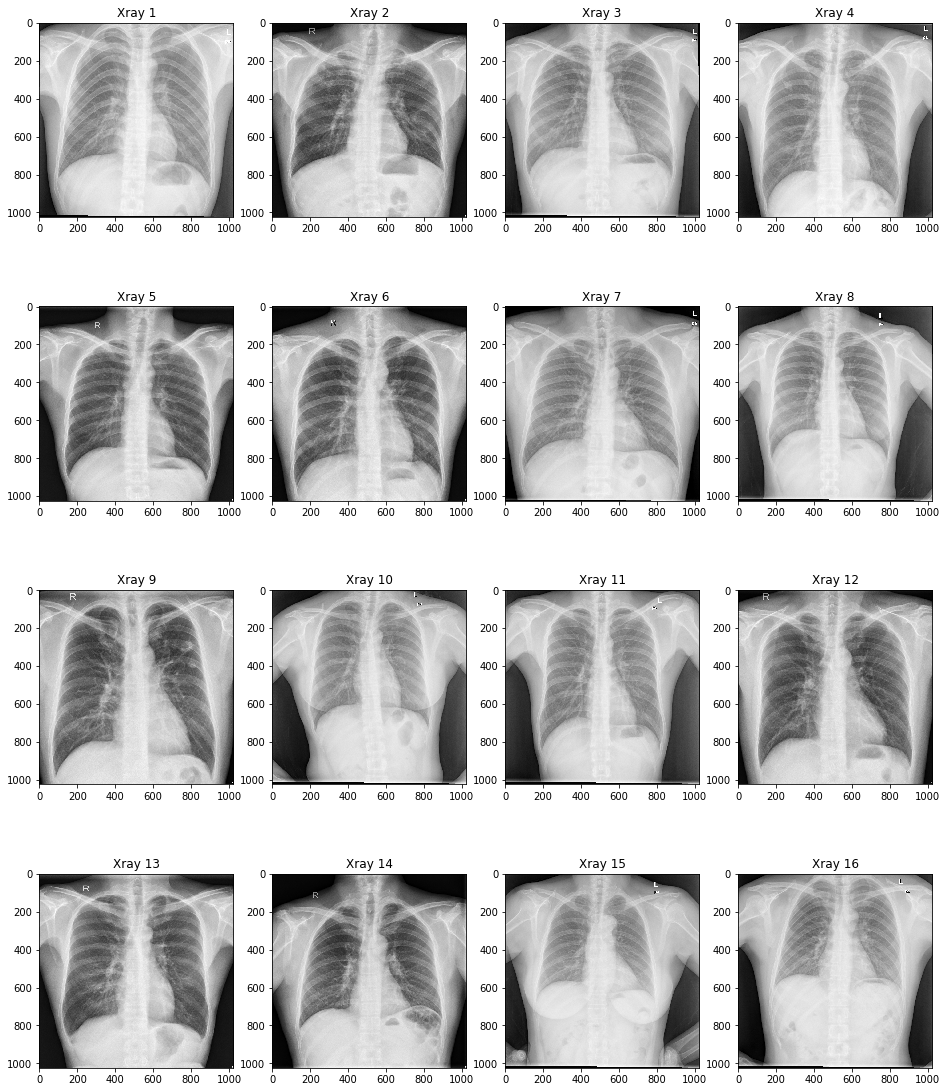

In [15]:
import cv2
def plot_multiple_images(image_dataframe, rows = 4, columns = 4, figsize = (16, 20), resize=(1024,1024), preprocessing=None):
    image_dataframe = image_dataframe.reset_index(drop=True)
    fig = plt.figure(figsize=figsize)
    ax  = []

    for i in range(rows * columns):
        img = plt.imread(image_dataframe.loc[i,'filepath'])
        img = cv2.resize(img, resize)
        
        if preprocessing:
            img = preprocessing(img)
        
        ax.append(fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title("Xray "+str(i+1))
        plt.imshow(img, alpha=1, cmap='gray')
    
    plt.show()
plot_multiple_images(df)

In [16]:
batch_size = 32
input_size = (224,224)

train_df, val_df = train_test_split(df,
                                    test_size    = 0.2,
                                    random_state = 451)

train_generator = ImageDataGenerator(rescale = 1./255,
                                     horizontal_flip = True,
                                     zoom_range      = 0.1,
                                     shear_range     = 0,
                                     rotation_range  = 5,
                                     width_shift_range  = 0.05,
                                     height_shift_range = 0.05,
                                     fill_mode = 'constant',
                                     cval      = 0)

train = train_generator.flow_from_dataframe(dataframe = train_df,
                                    class_mode  = 'binary',
                                    x_col       = 'filepath',
                                    y_col       = 'target',
                                    shuffle     = True,
                                    batch_size  = batch_size,
                                    target_size = input_size,
                                    seed=451)

val = train_generator.flow_from_dataframe(dataframe = val_df,
                                         class_mode  = 'binary',
                                         x_col       = 'filepath',
                                         y_col       = 'target',
                                         shuffle     = True,
                                         batch_size  = batch_size,
                                         target_size = input_size,
                                         seed=451)

Found 529 validated image filenames belonging to 2 classes.
Found 133 validated image filenames belonging to 2 classes.


In [22]:
model = models.Sequential()

# Add Pretrained Model
model.add(applications.ResNet50V2(weights = 'imagenet', input_shape = (224,224,3), include_top=False))

# Add FC and Output layers
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile Model
model.compile(optimizer=optimizers.Adam(lr=5e-5), loss='binary_crossentropy', metrics=['acc'])
model.summary()

94674944/94668760 [==============================] - 8s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                102450    
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 23,667,301
Trainable params: 23,621,861
Non-trainable params: 45,440
_________________________________________________________________


In [0]:
# from tensorboardcolab import *
# tbc=TensorBoardColab(startup_waiting_time=30)

reduce_lr_op = callbacks.ReduceLROnPlateau(verbose=1, factor=.2, patience=5, min_lr=2e-5)
chk_pnt = callbacks.ModelCheckpoint(verbose = 1, save_best_only=True, filepath='shenzen_model.hdf5')

In [0]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
 
class LearningRateDecay:
	def plot(self, epochs, title="Learning Rate Schedule"):
		# compute the set of learning rates for each corresponding
		# epoch
		lrs = [self(i) for i in epochs]
 
		# the learning rate schedule
		plt.style.use("ggplot")
		plt.figure()
		plt.plot(epochs, lrs)
		plt.title(title)
		plt.xlabel("Epoch #")
		plt.ylabel("Learning Rate")

class PolynomialDecay(LearningRateDecay):
	def __init__(self, maxEpochs=20, initAlpha=0.01, power=1.0):
		# store the maximum number of epochs, base learning rate,
		# and power of the polynomial
		self.maxEpochs = maxEpochs
		self.initAlpha = initAlpha
		self.power = power
 
	def __call__(self, epoch):
		# compute the new learning rate based on polynomial decay
		decay = (1 - (epoch / float(self.maxEpochs))) ** self.power
		alpha = self.initAlpha * decay
 
		# return the new learning rate
		return float(alpha)
schedule = PolynomialDecay(maxEpochs=20, initAlpha=2e-4, power=5)
lr_scheduler = callbacks.LearningRateScheduler(schedule)

In [0]:
model.compile(optimizer=optimizers.Adam(lr=2e-4), loss='binary_crossentropy', metrics=['acc'])
model.fit_generator(
        train,
        callbacks = [reduce_lr_op, chk_pnt, lr_scheduler],
        epochs    = 15,
        steps_per_epoch  = train.samples // batch_size,
        validation_data  = val,
        validation_steps = val.samples // batch_size)

Epoch 1/15
11/16 [===================>..........] - ETA: 2:28 - loss: 0.6378 - acc: 0.7300

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp drive/"My Drive"/shenzen_model.hdf5 .

In [0]:
from tensorflow.keras.models import load_model

model = load_model('shenzen_model.hdf5')

In [11]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                102450    
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 23,667,301
Trainable params: 23,621,861
Non-trainable params: 45,440
_________________________________________________________________


In [13]:
test_df = pd.DataFrame(filelist_montgommery, columns=['filepath'])
test_df['target'] = labels_montgommery
test_df.head()

batch_size = 32
input_size = (224,224)

test_generator = ImageDataGenerator(rescale = 1./255,
                                    horizontal_flip = True,
                                    zoom_range      = 0.1,
                                    shear_range     = 0,
                                    rotation_range  = 5,
                                    width_shift_range  = 0.05,
                                    height_shift_range = 0.05,
                                    fill_mode = 'constant',
                                    cval      = 0)

test = test_generator.flow_from_dataframe(dataframe = test_df,
                                          class_mode  = 'binary',
                                          x_col       = 'filepath',
                                          y_col       = 'target',
                                          shuffle     = True,
                                          batch_size  = batch_size,
                                          target_size = input_size,
                                          seed=451)

model.evaluate_generator(test, steps = 15, verbose=1)

Found 138 validated image filenames belonging to 2 classes.
15/15 [==============================] - 193s 13s/step - loss: 0.9205 - acc: 0.5507


[0.9205431739489237, 0.5507246]